<a href="https://colab.research.google.com/github/Melo97/topicos_contemporaneos/blob/main/Projeto_FInal_1_T%C3%B3picos_Contempor%C3%A2neos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Projeto Final 1 -  Fine-Tuning de uma CNN para Classificação

Descrição do Projeto:
- Um dataset de sua escolha deverá ser coletado e preparado para realizar o fine-tuning de uma CNN. O projeto será avaliado nos seguintes aspectos:<br>
1. Construção do Dataset;
2. Data Augmentation;
3. Uso de Modelos Pré-Treinados;
4. Construção do Modelo Classificador;
5. Congelamento de Camadas;
6. Treinamento e Curvas de Desempenho;


Dataset: Fashion MNIST

```
About Dataset
Context
Fashion-MNIST is a dataset of Zalando's article images—consisting of a training set of 60,000 examples and a test set of 10,000 examples. Each example is a 28x28 grayscale image, associated with a label from 10 classes. Zalando intends Fashion-MNIST to serve as a direct drop-in replacement for the original MNIST dataset for benchmarking machine learning algorithms. It shares the same image size and structure of training and testing splits.

The original MNIST dataset contains a lot of handwritten digits. Members of the AI/ML/Data Science community love this dataset and use it as a benchmark to validate their algorithms. In fact, MNIST is often the first dataset researchers try. "If it doesn't work on MNIST, it won't work at all", they said. "Well, if it does work on MNIST, it may still fail on others."

Zalando seeks to replace the original MNIST dataset

Content
Each image is 28 pixels in height and 28 pixels in width, for a total of 784 pixels in total. Each pixel has a single pixel-value associated with it, indicating the lightness or darkness of that pixel, with higher numbers meaning darker. This pixel-value is an integer between 0 and 255. The training and test data sets have 785 columns. The first column consists of the class labels (see above), and represents the article of clothing. The rest of the columns contain the pixel-values of the associated image.

To locate a pixel on the image, suppose that we have decomposed x as x = i * 28 + j, where i and j are integers between 0 and 27. The pixel is located on row i and column j of a 28 x 28 matrix.
For example, pixel31 indicates the pixel that is in the fourth column from the left, and the second row from the top, as in the ascii-diagram below.


Labels

Each training and test example is assigned to one of the following labels:

0 T-shirt/top
1 Trouser
2 Pullover
3 Dress
4 Coat
5 Sandal
6 Shirt
7 Sneaker
8 Bag
9 Ankle boot


TL;DR

Each row is a separate image
Column 1 is the class label.
Remaining columns are pixel numbers (784 total).
Each value is the darkness of the pixel (1 to 255)
Acknowledgements
Original dataset was downloaded from https://github.com/zalandoresearch/fashion-mnist
```



In [5]:
#importações
import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

#cv
import torchvision
import torchvision.transforms as transforms

#EVAL
from sklearn.metrics import confusion_matrix

In [12]:
import matplotlib.pyplot as plt

In [4]:
# tentando usar máquina nvidia
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [6]:
train_set = torchvision.datasets.FashionMNIST("./data", download=True,
                                              transform= transforms.Compose([transforms.ToTensor()])
                                              )
test_set = torchvision.datasets.FashionMNIST("./data", download=True, train=False,
                                             transform= transforms.Compose([transforms.ToTensor()])
                                               )

100%|██████████| 26421880/26421880 [00:09<00:00, 2871596.97it/s] 


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 301550.40it/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:02<00:00, 1723008.00it/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 5456729.09it/s]


Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



In [10]:
train_set

Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
           )

In [11]:
test_set

Dataset FashionMNIST
    Number of datapoints: 10000
    Root location: ./data
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
           )

In [7]:
train_loader = DataLoader(train_set, batch_size=100)
test_loader = DataLoader(test_set,   batch_size=100)

<class 'torch.Tensor'> <class 'torch.Tensor'>


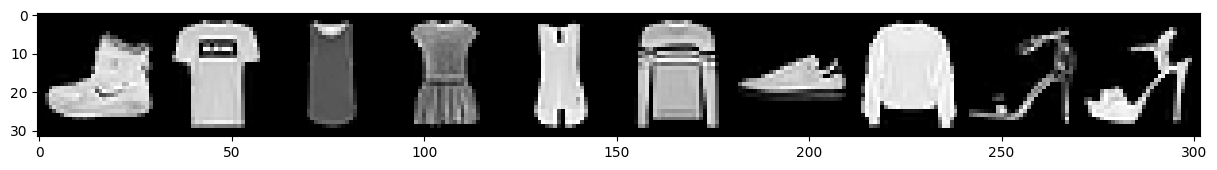

In [14]:
#Visualizando imagens:
amostra = DataLoader(train_set, batch_size=10)

images, labels = next(iter(amostra))

grid = torchvision.utils.make_grid(images, nrow=10)

plt.figure(figsize=(15, 20))
plt.imshow(np.transpose(grid, (1, 2, 0)))



In [17]:
#Classif. das imagens coletadas:
for i, label in enumerate(labels):
    print(label, end=", ")

tensor(9), tensor(0), tensor(0), tensor(3), tensor(0), tensor(2), tensor(7), tensor(2), tensor(5), tensor(5), 

Referencia dos valores:
0 T-shirt/top
1 Trouser
2 Pullover
3 Dress
4 Coat
5 Sandal
6 Shirt
7 Sneaker
8 Bag
9 Ankle boot

In [20]:
# Construindo Rede:

class CNN(nn.Module):

    def __init__(self):
        super(CNN, self).__init__()

        self.conv_layer1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.conv_layer2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        self.fc1 = nn.Linear(in_features=64*6*6, out_features=600)
        self.drop = nn.Dropout2d(0.25)
        self.fc2 = nn.Linear(in_features=600, out_features=120)
        self.fc3 = nn.Linear(in_features=120, out_features=10)

    def forward(self, x):
        x = self.conv_layer1(x)
        x = self.conv_layer2(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.drop(x)
        x = self.fc2(x)

        return self.fc3(x)

In [18]:
from tqdm import tqdm

# Definindo treinamento como nas aulas:

def train_model(model, trainloader, criterion, optimizer, num_epochs=5):
    train_losses = []
    accuracies = []
    for epoch in range(num_epochs):
        running_loss = 0.0
        correct = 0
        total = 0
        for i, data in tqdm(enumerate(trainloader, 0), total=len(trainloader)):
            # Obter os inputs; data é uma lista de [inputs, labels]
            inputs, labels = data

            # Zerar os gradientes dos parâmetros otimizados
            optimizer.zero_grad()

            # forward + backward + otimize
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # Estatísticas
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            if i % 50 == 49:
                train_losses.append(running_loss / 100)
                running_loss = 0.0

        epoch_acc = 100 * correct / total
        accuracies.append(epoch_acc)
        print(f'Epoch {epoch+1}, Loss: {train_losses[-1]:.3f}, Accuracy: {epoch_acc:.2f}%')
    print('Treinamento concluído')
    return train_losses, accuracies

# DEfinindo testes como nas aulas

def test_model(model, testloader):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f'Acurácia da rede na base de teste: {100 * correct / total:.2f}%')


In [21]:
# Atribuindo rede
model = CNN()
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.003)

cnn_losses, cnn_accuracies = train_model(model, train_loader, criterion, optimizer)

  0%|          | 0/600 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1374: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)
100%|██████████| 600/600 [01:56<00:00,  5.14it/s]


Epoch 1, Loss: 0.181, Accuracy: 81.93%


100%|██████████| 600/600 [01:51<00:00,  5.39it/s]


Epoch 2, Loss: 0.147, Accuracy: 88.47%


100%|██████████| 600/600 [01:51<00:00,  5.40it/s]


Epoch 3, Loss: 0.135, Accuracy: 90.07%


100%|██████████| 600/600 [01:48<00:00,  5.51it/s]


Epoch 4, Loss: 0.119, Accuracy: 91.04%


100%|██████████| 600/600 [01:52<00:00,  5.35it/s]

Epoch 5, Loss: 0.111, Accuracy: 91.78%
Treinamento concluído


In [22]:
# Testando a CNN
test_model(model, test_loader)

Acurácia da rede na base de teste: 90.13%


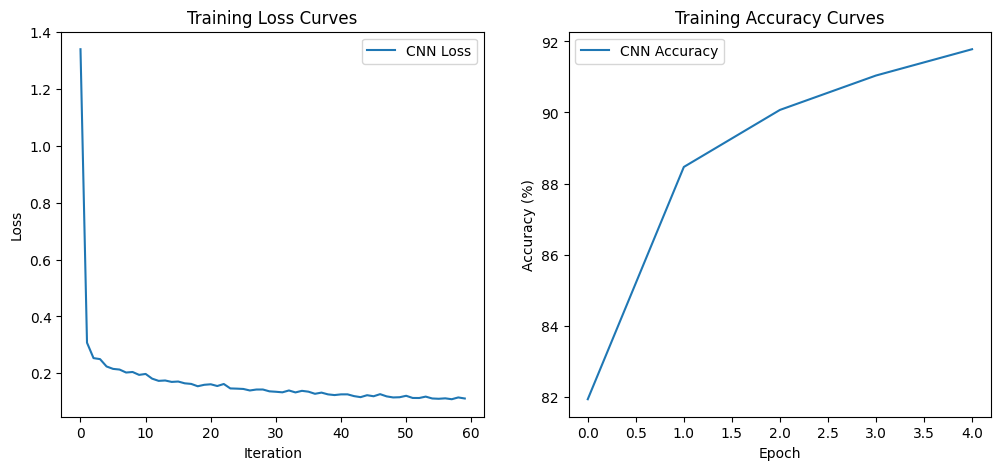

In [23]:
# Plotando perdas X Iterações e Acurácia X Epochs:

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(cnn_losses, label='CNN Loss')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Training Loss Curves')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(cnn_accuracies, label='CNN Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training Accuracy Curves')
plt.legend()

plt.show()

## Data Augmentation

In [34]:
# Carregando os datasets
transform_aug = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
   transforms.Normalize((0.5,), (0.5,))
])

transform_no_aug = transforms.Compose([
    transforms.Resize(230),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
   transforms.Normalize((0.5,), (0.5,))
])

train_set_aug = torchvision.datasets.FashionMNIST("./data", download=True, transform= transform_aug)
val_set_aug = torchvision.datasets.FashionMNIST("./data", download=True, train=False, transform= transform_no_aug)

train_loader_aug = DataLoader(train_set_aug, batch_size=100, shuffle=True)
val_loader_aug = DataLoader(val_set_aug, batch_size=100, shuffle=True)

In [36]:
# Atribuindo rede
class CNN_aug(nn.Module):
    def __init__(self):
        super(CNN_aug, self).__init__()
        self.conv_layer1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.conv_layer2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        # Calculate the correct input size for fc1
        self.fc1 = nn.Linear(64 * 5 * 5, 600)  # Adjusted input size
        self.drop = nn.Dropout2d(0.25)
        self.fc2 = nn.Linear(600, 10)

    def forward(self, x):
        x = self.conv_layer1(x)
        x = self.conv_layer2(x)
        x = x.view(x.size(0), -1)  # Flatten the output
        x = self.fc1(x)
        x = self.drop(x)
        x = self.fc2(x)
        return x

model_aug = CNN_aug()
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_aug.parameters(), lr=0.003)

cnn_losses_aug, cnn_accuracies_aug = train_model(model_aug, train_loader_aug, criterion, optimizer)

  0%|          | 0/600 [00:07<?, ?it/s]


RuntimeError: mat1 and mat2 shapes cannot be multiplied (100x193600 and 1600x600)

In [27]:
# Testando a CNN
test_model(model_aug, val_loader_aug)

# Plotando perdas X Iterações e Acurácia X Epochs:

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(cnn_losses_aug, label='CNN aug Loss')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Training Loss Curves')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(cnn_accuracies_aug, label='CNN aug Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training Accuracy Curves')
plt.legend()

plt.show()

RuntimeError: output with shape [1, 224, 224] doesn't match the broadcast shape [3, 224, 224]